In [1]:
import os
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report

In [2]:
print(os.getcwd())

C:\Users\Mattijs\Documents\Mattijs\GlobeDX\deep-orderbook


In [3]:
os.chdir('..')
os.chdir('Data')
print(os.getcwd())

C:\Users\Mattijs\Documents\Mattijs\GlobeDX\Data


In [4]:
register = {}

In [28]:
def concat_data(base_path, features):
    """Concatenate all the files in basepath keeping only the
    columns specified by features.
    """
    l2_snapshot = pd.DataFrame()
    for i, x in enumerate(tqdm(os.listdir(base_path))): 
        path = base_path + x
        df_hour = pd.read_parquet(path, columns=features)
        l2_snapshot = pd.concat([l2_snapshot, df_hour.dropna()])
        
    return l2_snapshot

def extend_matrix(a, n):
    """Extend a one row matrix to n rows by duplicating rows"""
    a = np.repeat(a, repeats=n, axis=0)
    return a

def normalise_data_per_day(df):
    df_mean = df.resample('D').mean()
    df_var = df.resample('D').var()
    
    timestamps_per_day = np.unique(df.index.date, return_counts=True)[1]
    mean_array = extend_matrix(df_mean.to_numpy(), timestamps_per_day)
    var_array = extend_matrix(df_var.to_numpy(), timestamps_per_day)
    
    df = (df - mean_array) / var_array

    return df

def generate_features_labels(df, best_ask_column='a1', best_bid_column='b1', k=20, alpha=10e-5):
    df['mid_price'] = (df[ask].to_numpy()+df[bid].to_numpy())/2
    df['target'] = 1
    
    
    index = df_.columns.get_loc('mid_price')
    target_index = df_.columns.get_loc('target')
    shape = df_.shape[0]
    y = df_['target'].to_numpy()
    for i in tqdm(range(k,shape-k)):
        if i==k:
            m_b = np.mean(df_.iloc[(i-k):i, index].to_numpy())
            m_a = np.mean(df_.iloc[i+1:(i+k+1), index].to_numpy())
            val = df_.iloc[i-k,index]
            valB = df_.iloc[i+1, index]
        else:
            curr_val = df_.iloc[i-1,index]
            curr_valB = df_.iloc[i+k, index]
            m_b = (m_b*k+(curr_val)-(val))/k
            m_a = (m_a*k+(curr_valB - valB))/k
            val = df_.iloc[(i-k),index]
            valB = df_.iloc[(i+1), index]

        if (m_b > m_a*(1+alpha)):
            y[i] = 2
        if (m_b < m_a*(1-alpha)):
            y[i] = 0

    y = y[k:shape-k]
    X = df.iloc[k:shape-k,:].to_numpy()
    return X,y

In [7]:
features = ['b1','b2','b3','b4','b5','b6','b7','b8', 'b9', 'b10', 'a1','a2','a3','a4','a5','a6','a7','a8', 'a9', 'a10', 'bq1','bq2','bq3','bq4','bq5','bq6','bq7','bq8', 'bq9', 'bq10', 'aq1','aq2','aq3','aq4','aq5','aq6','aq7','aq8', 'aq9', 'aq10']
base_path = 'coinbase_btc_usd/coinbase/btc_usd/l2_snapshots/100ms/'

l2_snapshot = concat_data(base_path, features)
l2_norm = normalise_data_per_day(l2_snapshot)

  0%|                                                                          | 0/216 [00:00<?, ?it/s]c:\users\mattijs\anaconda3\envs\globedx\lib\site-packages\pyarrow\pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
c:\users\mattijs\anaconda3\envs\globedx\lib\site-packages\pyarrow\pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
c:\users\mattijs\anaconda3\envs\globedx\lib\site-packages\pyarrow\pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels
100%|████████████████████████████████████████████████████████████████| 216/216 [07:21<00:00,  2.04s/it]


In [ ]:
count = 0
i = 0
register = {}
for i, x in enumerate(tqdm(os.listdir(base_path))):
    path = base_path+x
    if count%24 == 0:
        day = pd.read_parquet(path)
    else:
        temp = pd.read_parquet(path)
        day = pd.concat([day,temp])
  
    count += 1

    if count%24 == 0:
        flag = not register
        day = day.dropna()
        print(day.shape)
        result = []
        for cols in day.columns:
            values = day[cols].to_numpy()
            mean = np.mean(values)
            std = np.std(values)
            result.append([cols,[mean,std]])
        register[count/24] = result
        if not flag:
            for l in range(200):
                prev_stat = register[(count/24)-1]
                col_name = prev_stat[l][0]
                col_mean = prev_stat[l][1][0]
                col_std = prev_stat[l][1][1]
                values = day[col_name].to_numpy()
                values = (values - col_mean)/col_std
                day[col_name] = values
            l2_snapshot = pd.concat([l2_snapshot, day])
        del day
    if i > 240:
        break
    i += 1

 11%|██████▉                                                          | 23/216 [00:25<07:52,  2.45s/it]

(619075, 200)


 22%|██████████████▏                                                  | 47/216 [01:13<07:10,  2.55s/it]

(592272, 200)


c:\users\mattijs\anaconda3\envs\globedx\lib\site-packages\ipykernel_launcher.py:34: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

 33%|█████████████████████▎                                           | 71/216 [02:45<07:36,  3.15s/it]

(600695, 200)


In [10]:
l2_snapshot_ = l2_snapshot[['b1','b2','b3','b4','b5','b6','b7','b8', 'b9', 'b10', 'a1','a2','a3','a4','a5','a6','a7','a8', 'a9', 'a10', 'bq1','bq2','bq3','bq4','bq5','bq6','bq7','bq8', 'bq9', 'bq10', 'aq1','aq2','aq3','aq4','aq5','aq6','aq7','aq8', 'aq9', 'aq10']]

KeyError: "None of [Index(['b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8', 'b9', 'b10', 'a1', 'a2',\n       'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'a10', 'bq1', 'bq2', 'bq3',\n       'bq4', 'bq5', 'bq6', 'bq7', 'bq8', 'bq9', 'bq10', 'aq1', 'aq2', 'aq3',\n       'aq4', 'aq5', 'aq6', 'aq7', 'aq8', 'aq9', 'aq10'],\n      dtype='object')] are in the [columns]"

In [11]:
l2_snapshot_ # As previous day is used, first day 12/11 can't be normalised so not used

NameError: name 'l2_snapshot_' is not defined

In [ ]:
def generate_features_labels(df, ask, bid, k=20, alpha=10e-5):
    df_ = df.copy()
    df_['mid_price'] = (df_[ask].to_numpy()+df_[bid].to_numpy())/2
    df_['target'] = 1
    index = df_.columns.get_loc('mid_price')
    target_index = df_.columns.get_loc('target')
    shape = df_.shape[0]
    y = df_['target'].to_numpy()
    for i in tqdm(range(k,shape-k)):
        if i==k:
            m_b = np.mean(df_.iloc[(i-k):i, index].to_numpy())
            m_a = np.mean(df_.iloc[i+1:(i+k+1), index].to_numpy())
            val = df_.iloc[i-k,index]
            valB = df_.iloc[i+1, index]
        else:
            curr_val = df_.iloc[i-1,index]
            curr_valB = df_.iloc[i+k, index]
            m_b = (m_b*k+(curr_val)-(val))/k
            m_a = (m_a*k+(curr_valB - valB))/k
            val = df_.iloc[(i-k),index]
            valB = df_.iloc[(i+1), index]

        if (m_b > m_a*(1+alpha)):
            y[i] = 2
        if (m_b < m_a*(1-alpha)):
            y[i] = 0

    y = y[k:shape-k]
    X = df.iloc[k:shape-k,:].to_numpy()
    return X,y

In [ ]:
X,y = generate_features_labels(l2_snapshot, ask='a1', bid = 'b1', alpha=5)
#X_dif, y_dif = generate_features_labels_dif(l2_snapshot, ask='a1', bid = 'b1', alpha=5)

In [11]:
# GridSearch
min_ = float('inf')
minI = 0
for i in np.logspace(-5,-20,20, endpoint = True):
    X,y = generate_features_labels(l2_snapshot, ask='a1', bid = 'b1', alpha=i)
    y_ = pd.Series(y)
    temp = y_.value_counts()
    a,b,c = temp[0], temp[1], temp[2]
    sum_ = a+b+c
    l2 = ((((1/3-(a/sum_)))**2 + ((1/3-(b/sum_)))**2 + ((1/3-(c/sum_)))**2)/3)**2
    if l2 < min_:
        min_ = l2
        minI = i
    print(min_, minI)

100%|██████████| 4272627/4272627 [03:31<00:00, 20197.93it/s]


0.00013868441206975815 1e-05


100%|██████████| 4272627/4272627 [03:33<00:00, 20038.27it/s]


0.00013526902372066352 1.6237767391887209e-06


100%|██████████| 4272627/4272627 [03:32<00:00, 20093.78it/s]


0.00013418161979081682 2.6366508987303554e-07


100%|██████████| 4272627/4272627 [03:32<00:00, 20097.20it/s]


0.00013418161979081682 2.6366508987303554e-07


100%|██████████| 4272627/4272627 [03:33<00:00, 20058.69it/s]


0.00013418161979081682 2.6366508987303554e-07


100%|██████████| 4272627/4272627 [03:27<00:00, 20622.28it/s]


0.00013418161979081682 2.6366508987303554e-07


100%|██████████| 4272627/4272627 [03:24<00:00, 20869.89it/s]


0.00013361650734055707 1.8329807108324374e-10


100%|██████████| 4272627/4272627 [03:28<00:00, 20497.76it/s]


0.00012882650973723323 2.976351441631313e-11


100%|██████████| 4272627/4272627 [03:28<00:00, 20480.15it/s]


9.658366965582295e-05 4.832930238571752e-12


100%|██████████| 4272627/4272627 [03:28<00:00, 20446.17it/s]


1.726301745302494e-05 7.847599703514623e-13


100%|██████████| 4272627/4272627 [03:30<00:00, 20279.20it/s]


1.726301745302494e-05 7.847599703514623e-13


100%|██████████| 4272627/4272627 [03:32<00:00, 20139.19it/s]


1.726301745302494e-05 7.847599703514623e-13


100%|██████████| 4272627/4272627 [03:29<00:00, 20367.75it/s]


1.726301745302494e-05 7.847599703514623e-13


100%|██████████| 4272627/4272627 [03:31<00:00, 20181.92it/s]


1.726301745302494e-05 7.847599703514623e-13


100%|██████████| 4272627/4272627 [03:31<00:00, 20212.11it/s]


1.726301745302494e-05 7.847599703514623e-13


100%|██████████| 4272627/4272627 [03:32<00:00, 20144.75it/s]


1.726301745302494e-05 7.847599703514623e-13


100%|██████████| 4272627/4272627 [03:33<00:00, 20011.01it/s]


1.726301745302494e-05 7.847599703514623e-13


100%|██████████| 4272627/4272627 [03:34<00:00, 19949.52it/s]


1.726301745302494e-05 7.847599703514623e-13


100%|██████████| 4272627/4272627 [03:36<00:00, 19778.27it/s]


1.726301745302494e-05 7.847599703514623e-13


100%|██████████| 4272627/4272627 [03:31<00:00, 20160.60it/s]


1.726301745302494e-05 7.847599703514623e-13


In [12]:
print(minI, min_)

7.847599703514623e-13 1.726301745302494e-05


In [9]:
X,y = generate_features_labels(l2_snapshot_, ask='a1', bid = 'b1', alpha=7.847599703514623e-13)

100%|██████████| 4272627/4272627 [03:02<00:00, 23408.96it/s]


In [10]:
l2_snapshot_['mid_price'] = (l2_snapshot_['b1']+l2_snapshot_['a1'])/2

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


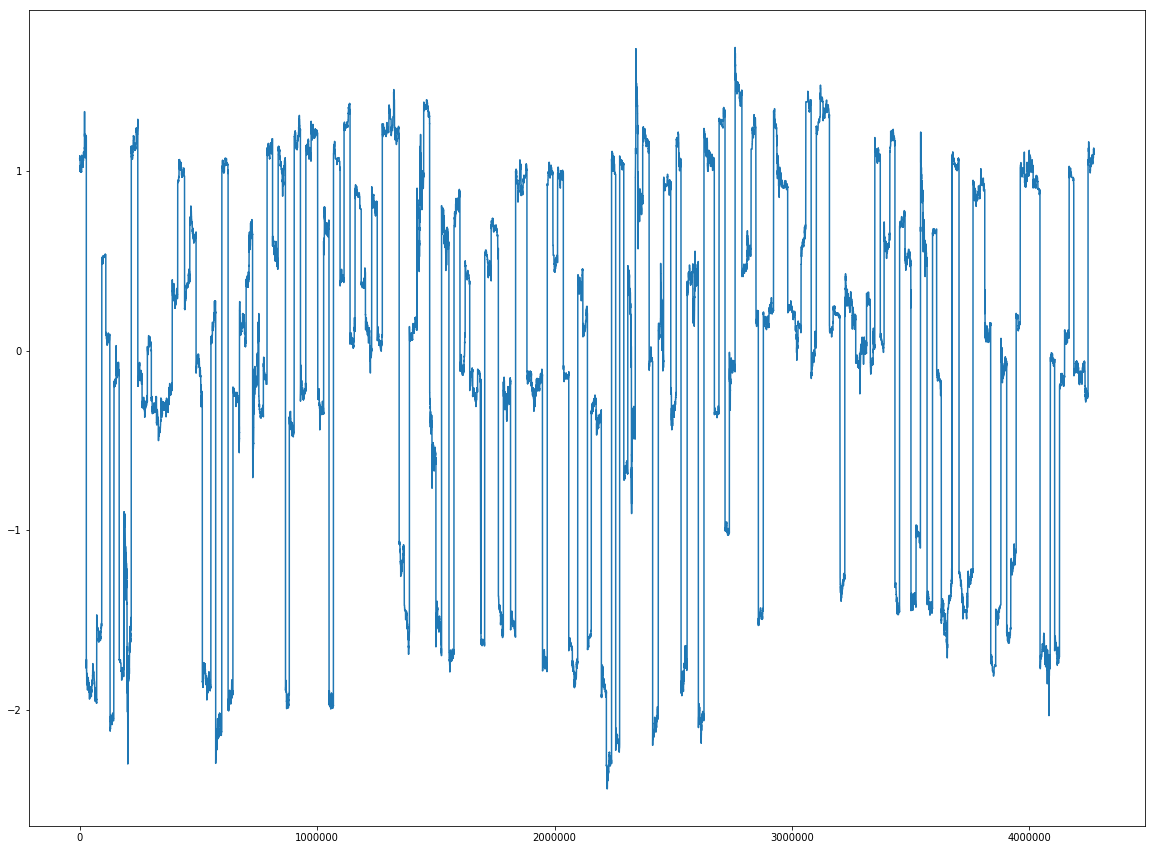

In [11]:
plt.figure(figsize = (20,15))
plt.plot(np.arange(1,l2_snapshot_.shape[0]+1), l2_snapshot_['mid_price'])

In [12]:
y = y.astype('int')

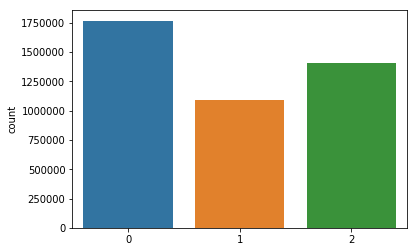

In [13]:
sns.countplot(x = y)

In [14]:
T = 100
D = 40
N = len(X) - T

In [15]:
trainPart = 3176026

In [16]:
X_train = np.zeros((trainPart, T, D), dtype = 'float32')
y_train = np.zeros(trainPart, dtype='float32')

#Preparing the time series data using timestep of 100 and no of features = 200
for t in range(trainPart):
    X_train[t, :, :] = X[t:t+T]
    y_train[t] = y[t+T] 


In [17]:
print('X_train - Before: {} GB'.format(X_train.nbytes/1024**3), X_train.dtype)

X_train - Before: 47.326475381851196 GB float32


In [18]:
print('y_train - Before: {} GB'.format(y_train.nbytes/1024**3), y_train.dtype)

y_train - Before: 0.011831618845462799 GB float32


In [19]:
X_test = np.zeros((N - trainPart, T, D), dtype = 'float32')
y_test = np.zeros(N - trainPart, dtype='float32')

#Preparing the time series data using timestep of 100 and no of features = 40
for k in range(N - trainPart):
    t = k + trainPart
    X_test[k, :, :] = X[t:t+T]
    y_test[k] = y[t+T]

print('X_test - Before: {} GB'.format(X_test.nbytes/1024**3), X_test.dtype)
print('y_test - Before: {} GB'.format(y_test.nbytes/1024**3), y_test.dtype)

X_test - Before: 16.33913815021515 GB float32
y_test - Before: 0.004084784537553787 GB float32


In [20]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [21]:
!pip install tensorflow-addons

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Defaulting to user installation because normal site-packages is not writeable


In [22]:
import tensorflow_addons as tfa

In [23]:
from tensorflow.keras.layers import Input, Conv1D, Conv2D, Flatten, MaxPooling1D, MaxPooling2D, Dense, LeakyReLU, Bidirectional, LSTM, Add, Activation, GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.compat.v1.keras.layers import CuDNNLSTM

In [24]:
from tensorflow import keras
from functools import partial

In [25]:
## Resnet of Conv1D
DefaultConv1D = partial(keras.layers.Conv1D, kernel_size=4, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv1D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv1D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv1D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [26]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    inputs = keras.layers.Input(shape = (100,40))
    x = keras.layers.Conv1D(filters=16, kernel_size=4 ,activation='relu', padding='SAME')(inputs)
    x = keras.layers.MaxPooling1D(2)(x)
    
    prev_filters = 16
    for filters in [16]*3+[32]*2:
        if prev_filters != filters:
            stride = 2
        else:
            stride = 1
        x = ResidualUnit(filters, stride)(x)
        prev_filters = filters

    x = keras.layers.GlobalAveragePooling1D()(x)
    outputs = keras.layers.Dense(3, activation='softmax')(x)

    res_net_model = keras.models.Model(inputs, outputs)
    res_net_model.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task

In [27]:
# strategy = tf.distribute.MirroredStrategy()
# with strategy.scope():
#     i = Input(shape=X_train[0].shape)
    
#     x = Conv2D(16, (4,D),kernel_initializer="he_normal")(i)
#     x = LeakyReLU(alpha=0.01)(x)
#     x = tf.keras.layers.BatchNormalization()(x)
    
#     x = tf.keras.layers.Reshape(target_shape=(T-3,16))(x)
    
#     x = Conv1D(16, 4, kernel_initializer="he_normal")(x)
#     x = LeakyReLU(alpha=0.01)(x)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = MaxPooling1D(2)(x)
    
#     x = Conv1D(32, 3, activation=LeakyReLU(alpha=0.01), kernel_initializer="he_normal")(x)
#     x = LeakyReLU(alpha=0.01)(x)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = MaxPooling1D(2)(x)
    
#     x = Bidirectional(LSTM(64, return_sequences = False))(x)
    
#     x = Dense(32 ,kernel_initializer="he_normal")(x)
#     x = LeakyReLU(alpha=0.01)(x)
#     x = tf.keras.layers.BatchNormalization()(x)
    
#     x = Dense(32, kernel_initializer="he_normal")(x)
#     x = LeakyReLU(alpha=0.01)(x)
#     x = tf.keras.layers.BatchNormalization()(x)
    
#     x = Dense(3, activation='softmax', kernel_initializer="he_normal")(x)

#     model = Model(i,x)
#     model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])
    

In [28]:
EPOCHS = 2
r = res_net_model.fit(
    X_train,y_train,
    epochs=EPOCHS,
    batch_size=128
)

Train on 3176026 samples
Epoch 1/2
INFO:tensorflow:batch_all_reduce: 37 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:batch_all_reduce: 37 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
3176026/3176026 [==============================] - 761s 240us/sample - loss: 0.5298 - accuracy: 0.7703
Epoch 2/2
3176026/3176026 [==============================] - 672s 212us/sample - loss: 0.4726 - accuracy: 0.8007


In [29]:
res_net_model.evaluate(X_test, y_test)

1096501/1096501 [==============================] - 263s 240us/sample - loss: 0.5219 - accuracy: 0.7813


[0.5219288663517122, 0.78128153]

In [30]:
y_pred = res_net_model.predict(X_test)

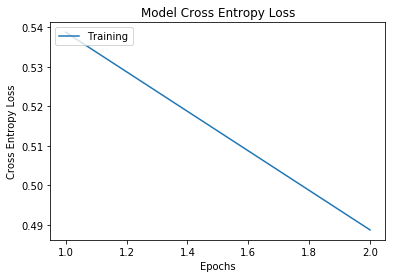

In [24]:
sns.lineplot(x=range(1,EPOCHS+1),y=r.history['loss'])
#sns.lineplot(x=range(1,EPOCHS+1),y=r.history['val_loss'])
plt.title('Model Cross Entropy Loss')
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Epochs')
plt.legend(['Training'], loc='upper left')

In [31]:
y_pred = y_pred.argmax(axis=1)

In [26]:
with strategy.scope():
    y_pred = model.predict(X_test).argmax(axis=1)

InternalError: 2 root error(s) found.
  (0) Internal:  No algorithm worked!
	 [[node replica_3/model/bidirectional/forward_cu_dnnlstm/CudnnRNNV2 (defined at /lib/python3.5/threading.py:914) ]]
  (1) Internal:  No algorithm worked!
	 [[node replica_3/model/bidirectional/forward_cu_dnnlstm/CudnnRNNV2 (defined at /lib/python3.5/threading.py:914) ]]
	 [[GroupCrossDeviceControlEdges_0/Identity_2/_73]]
0 successful operations.
2 derived errors ignored. [Op:__inference_distributed_function_962908]

Function call stack:
distributed_function -> distributed_function


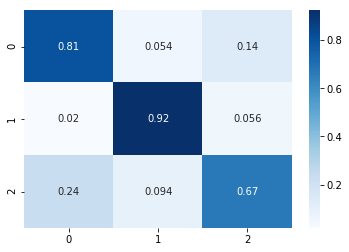

In [32]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
    
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

ax=sns.heatmap(cm, annot=True, xticklabels=[0,1,2], yticklabels=[0,1,2], cmap='Blues')
ax.set_ylim(3.0, 0)
plt.show()

In [33]:
print(classification_report(y_test,y_pred))

             precision    recall  f1-score   support

        0.0       0.79      0.81      0.80    469694
        1.0       0.77      0.92      0.84    227557
        2.0       0.77      0.67      0.72    399250

avg / total       0.78      0.78      0.78   1096501

